In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import math
import os
from pathlib import Path
import sys

In [3]:
from PIL import Image as PILImage
from PIL import ImageChops as PILImageChops
from fastai import *
from fastai.vision import *
from fastai.vision.transform import *
from fastai.vision.image import TfmAffine
from fastai.metrics import accuracy
from torchvision.transforms import functional as vision_transform

In [4]:
parent_dir = Path.cwd().parent.as_posix()
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [5]:
from basedir import PREPARED, TEST, MODELS
from dataset import QuickDraw, TestImagesFolder
from logger import get_logger
from utils import Predictor, Timer

In [6]:
np.random.seed(1)
defaults.device = torch.device('cuda:0')
log = get_logger(log_path='log.txt')
IMG_SIZE = 128, 128

In [7]:
trn_ds = QuickDraw(PREPARED, train=True, subset_size=200, img_size=IMG_SIZE, log=log)
val_ds = QuickDraw(PREPARED, train=False, subset_size=50, img_size=IMG_SIZE, log=log)
tst_ds = TestImagesFolder(TEST, img_size=IMG_SIZE)

[2018/11/18 15:04:39:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/train_200.feather
[2018/11/18 15:04:39:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/valid_50.feather


In [16]:
def create_bunch(train_path=PREPARED, test_path=TEST, subset_sizes=(200, 50), 
                 img_size=IMG_SIZE, bs=800, ds_tfms=None, show=True):
    trn_sz, val_sz = subset_sizes
    trn_ds = QuickDraw(train_path, train=True, subset_size=trn_sz, img_size=img_size, log=log)
    val_ds = QuickDraw(train_path, train=False, subset_size=val_sz, img_size=img_size, log=log)
    tst_ds = TestImagesFolder(test_path, img_size=img_size)
    bunch = ImageDataBunch.create(trn_ds, val_ds, tst_ds, bs=bs, num_workers=4, ds_tfms=ds_tfms)
    bunch.normalize(imagenet_stats)
    if show:
        bunch.show_batch(rows=4)
    return bunch

In [29]:
def trim(img):
    bg = PILImage.new(img.mode, img.size, color='black')
    diff = PILImageChops.difference(img, bg)
    diff = PILImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        img = img.crop(bbox)
    return img

In [11]:
@TfmCrop
def strip_empty_space(x, size, **kwargs):
    """Crops the image to exclude empty space from the image and rescale it to oritinal size."""

    img = vision_transform.to_pil_image(x)
    trimmed = trim(img).resize(size)
    new = vision_transform.to_tensor(trimmed).to(x)
    return new

In [12]:
def mapk(y_pred, y_true, k):
    """Precision metric which compares several guesses with a single ground-truth value.
    
    Adapted from:
        https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
        
    """
    top_k = y_pred.argsort(descending=True)[:, :k]
    matched = top_k == y_true.view(-1, 1)
    map_k = 1/(matched.argmax(dim=1) + 1).float()
    return map_k.mean()

In [13]:
# Custom implementation of fastai's build-in functionality
#
# def show_batch(data_bunch, ds_type=DatasetType.Train, n=9, **fig_kwargs):
#     dl = data_bunch.dl(ds_type)
#     index = next(iter(dl.batch_sampler))[:n]
#     rows = int(math.sqrt(len(index)))
#     cols = n // rows
#     ds = dl.dataset
#     images = [ds[i][0] for i in index]
#     f, axes = plt.subplots(rows, cols, **fig_kwargs)
#     for img, ax in zip(images, axes.flat):
#         ax.imshow(img.data.permute(1, 2, 0))
#         ax.set_axis_off()

[2018/11/18 15:04:51:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/train_200.feather
[2018/11/18 15:04:51:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/valid_50.feather


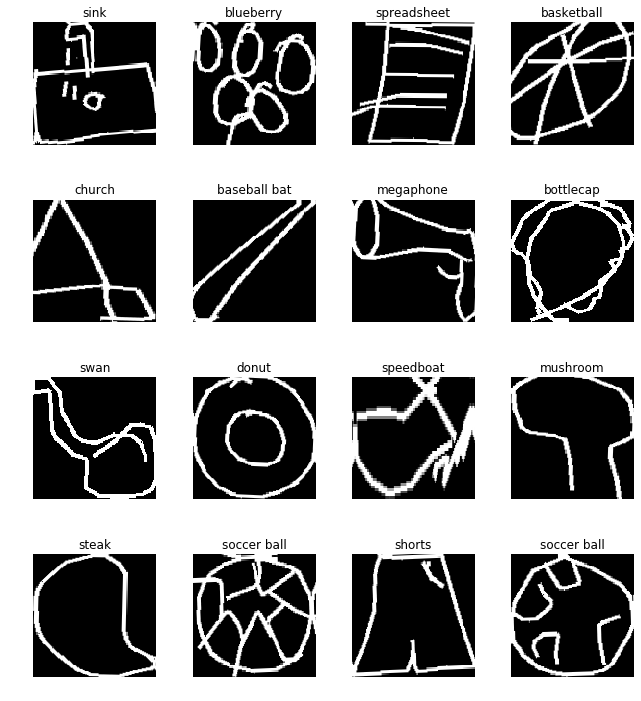

In [14]:
train_tfms = [
    strip_empty_space(),
    rand_crop(p=0.5),
    flip_affine(p=0.5),
    rotate(degrees=(-5, 5), p=0.75),
    rand_zoom(scale=(0.95, 1.15), p=0.5),
]

valid_tfms = [
    strip_empty_space(),
]

bunch = create_bunch(ds_tfms=(train_tfms, valid_tfms))

In [99]:
learn = create_cnn(bunch, models.resnet18)
learn.metrics = [accuracy, partial(mapk, k=3)]

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


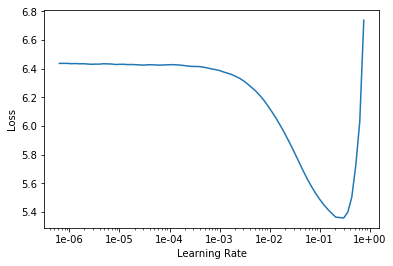

In [100]:
learn.lr_find()
learn.recorder.plot()

In [101]:
learn.fit_one_cycle(1, max_lr=1e-02, div_factor=10)

Total time: 00:46
epoch  train_loss  valid_loss  accuracy  mapk    
1      2.945424    1.964918    0.512941  0.881059  (00:46)



In [102]:
learn.fit_one_cycle(3, max_lr=1e-02/2, div_factor=10)

Total time: 02:19
epoch  train_loss  valid_loss  accuracy  mapk    
1      2.133851    1.786876    0.538706  0.879363  (00:47)
2      1.938075    1.535507    0.601412  0.888039  (00:46)
3      1.723269    1.456402    0.617765  0.889373  (00:46)



In [57]:
learn.save('base')

In [15]:
_ = learn.load('base')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


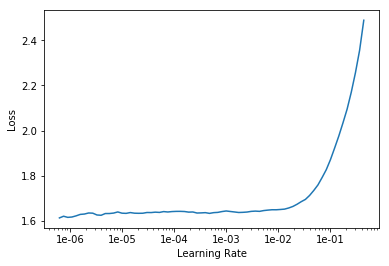

In [103]:
learn.unfreeze()
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot()

In [104]:
learn.fit_one_cycle(5, max_lr=slice(2e-04, 1e-03), div_factor=100)

Total time: 03:52
epoch  train_loss  valid_loss  accuracy  mapk    
1      1.637616    1.435560    0.623176  0.890382  (00:46)
2      1.621376    1.412111    0.626235  0.890549  (00:46)
3      1.587518    1.389972    0.632059  0.890833  (00:46)
4      1.545779    1.376720    0.634706  0.891431  (00:45)
5      1.520373    1.375370    0.634941  0.890441  (00:46)



In [25]:
learn.save('unfreeze_one')

In [27]:
_ = learn.load('unfreeze_one')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


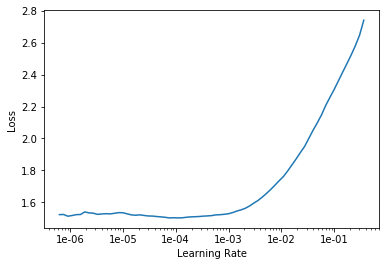

In [105]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [106]:
learn.fit_one_cycle(5, max_lr=slice(1e-04, 3e-04))

Total time: 04:15
epoch  train_loss  valid_loss  accuracy  mapk    
1      1.491473    1.313209    0.646176  0.893706  (00:46)
2      1.423106    1.253243    0.661647  0.896549  (00:46)
3      1.306460    1.170268    0.677353  0.897520  (00:49)
4      1.172128    1.121937    0.691176  0.901274  (00:56)
5      1.094888    1.113277    0.692294  0.901971  (00:55)



In [31]:
learn.save('unfreeze_all')

In [32]:
_ = learn.load('unfreeze_all')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


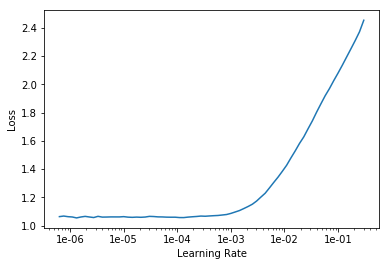

In [107]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [108]:
learn.fit_one_cycle(10, max_lr=slice(1e-05, 5e-04))

Total time: 09:25
epoch  train_loss  valid_loss  accuracy  mapk    
1      1.060296    1.105388    0.693235  0.901304  (00:56)
2      1.051283    1.101639    0.697588  0.902931  (00:56)
3      1.041154    1.108020    0.693706  0.901392  (00:56)
4      1.013819    1.095245    0.697882  0.903078  (00:56)
5      0.968246    1.082783    0.702647  0.904931  (00:56)
6      0.910897    1.069322    0.706294  0.904294  (00:56)
7      0.866832    1.061078    0.708706  0.905245  (00:57)
8      0.821621    1.053880    0.710647  0.906392  (00:55)
9      0.802426    1.051101    0.711176  0.906010  (00:56)
10     0.785039    1.050713    0.711294  0.906000  (00:56)



In [64]:
learn.save('full')
_ = learn.load('full')

In [42]:
tta = learn.TTA(ds_type=DatasetType.Test)

Total time: 15:14



In [48]:
preds, _ = tta

In [109]:
preds, _ = learn.get_preds(DatasetType.Test)

In [49]:
preds.shape

torch.Size([112199, 340])

In [110]:
keys = [path.stem for path in tst_ds.images]

In [24]:
def top_k(learn, logits, k=3):
    top_idx = logits.argsort()[:, -k:]
    top_classes = learn.data.classes[top_idx]
    top_logits = logits[np.arange(len(logits)), top_idx.T].T
    return np.fliplr(top_classes), np.fliplr(top_logits)

In [25]:
def generate_submission_file(keys, classes, filename='submit.csv'):
    records = ['key_id,word']

    for key, top_classes in zip(keys, classes):
        str_classes = ' '.join(['_'.join(c.split()) for c in top_classes])
        records.append(f'{key},{str_classes}')

    with open('submit.csv', 'w') as file:
        for record in records:
            file.write(record + '\n')

In [113]:
classes, logits = top_k(learn, to_np(preds))

In [114]:
generate_submission_file(keys, classes)

In [115]:
!kaggle competitions submit  quickdraw-doodle-recognition -f submit.csv -m "ResNet18 div_factor"

100%|██████████████████████████████████████| 4.39M/4.39M [00:03<00:00, 1.26MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge

## Load Trained Model

In [37]:
test_images = TEST.ls()
def get_test_image(idx):
    return PILImage.open(test_images[idx]).convert("RGB")

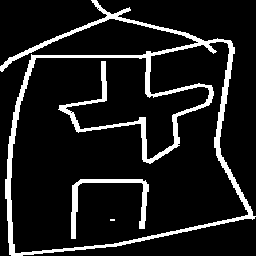

In [38]:
get_test_image(3)

In [44]:
bunch = create_bunch(ds_tfms=(train_tfms, valid_tfms), show=False)
learn = create_cnn(bunch, models.resnet50, path='..').load('unfreeze_all')

[2018/11/18 15:19:57:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/train_200.feather
[2018/11/18 15:19:57:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/valid_50.feather


In [45]:
preds, _ = learn.get_preds(DatasetType.Test)

In [46]:
keys = [path.stem for path in tst_ds.images]

In [47]:
classes, logits = top_k(learn, to_np(preds))

In [48]:
generate_submission_file(keys, classes)

In [49]:
!kaggle competitions submit  quickdraw-doodle-recognition -f submit.csv -m "ResNet50 stages training 5 epochs (no crop)"

100%|███████████████████████████████████████| 4.56M/4.56M [00:05<00:00, 842kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge